In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
plt.rcParams['font.size'] = 14
import pylab_util as PU

In [43]:
import control
import digcomp

In [44]:
import serial
import serial_utils

In [45]:
portname = '/dev/cu.usbmodem1421'

In [46]:
def read_all(ser):
    out = []
    while ser.in_waiting > 0:
        data1b = ser.read(1)
        data1 = data1b.decode('utf-8')
        out.append(data1)
        
    outstr = ''.join(out)
    return outstr

In [47]:
def print_all(ser):
    out = read_all(ser)
    print(out)

In [87]:
ser = serial.Serial(portname, 115200, timeout=1)
debug_line = serial_utils.Read_Line(ser)
line_str = ''.join(debug_line)
line_str

'minisegway new chassis'

In [88]:
print_all(ser)

sonar with MPU 6050 v. 1.2.0.3



In [89]:
ser.flushInput()
ser.flushOutput()
serial_utils.WriteByte(ser, 2)#start new test - force python to wait for Arduino to be ready
check_byte = serial_utils.Read_Two_Bytes(ser)
check_byte

2

In [90]:
# calibrate inverse deadband
serial_utils.WriteByte(ser, 4)

In [91]:
print_all(ser)

posbreak amp = 17
negbreak amp = -13
posbreak1: 17
negbreak1: -13
posbreak amp = 27
negbreak amp = -19
posbreak2: 27
negbreak2: -19



In [92]:
def start_ol_pulse_test(amp=50,width=100):
    serial_utils.WriteByte(ser, 6)#new n and voltage are coming
    serial_utils.WriteInt(ser, amp)
    serial_utils.WriteInt(ser, width)
    #serial_utils.WriteInt(ser, test_case) 

In [93]:
def get_data():
    data = ''
    i = 0
    num_empty = 0
    
    while i < 100:
        new_data = read_all(ser)
        data += new_data
        time.sleep(0.2)
        i += 1
        test_str = new_data.strip()
        if not test_str:
            num_empty += 1
        else:
            num_empty = 0
        
        if num_empty > 5:
            break
            
    return data

In [94]:
def set_stopn(n=300):
    serial_utils.WriteByte(ser, 9)
    serial_utils.WriteInt(ser, n)

In [95]:
def set_kp_kd(kp=1,kd=0.1):
    kp_int = int(100*kp)
    kd_int = int(1000*kd)
    serial_utils.WriteByte(ser, 8)
    serial_utils.WriteInt(ser, kp_int)
    serial_utils.WriteInt(ser, kd_int)

In [96]:
def start_pd_test():
    serial_utils.WriteByte(ser, 7)

In [97]:
def start_pd_debug_test():
    serial_utils.WriteByte(ser, 14)

In [98]:
def abort():
    serial_utils.WriteByte(ser, 250)

In [99]:
def daq_no_input():
    serial_utils.WriteByte(ser, 11)

In [100]:
print_all(ser)

In [101]:
def data_to_float_array(data):
    mylist = data.split('\n')
    clean_list = mylist[3:]
    clean_2 = list(filter(None,clean_list))
    nested_list = [row.split(',') for row in clean_2]
    str_array = np.array(nested_list)
    float_array = str_array.astype(float)
    return float_array

In [102]:
class data_plotter_sonar(object):
    def __init__(self, data):
        """save the columns of data to various attrs"""
        float_array = data_to_float_array(data)
        self.pwm1 = float_array[:,4]
        self.pwm2 = float_array[:,5]
        self.enc1 = float_array[:,6]
        self.enc2 = float_array[:,7]
        #theta1 = float_array[:,-3]
        #theta2 = float_array[:,-2]
        self.sonardiff = float_array[:,-4]
        self.t_ms = float_array[:,3]
        self.dt2 = float_array[:,-3]
        self.d2 = float_array[:,-5]
        self.d1 = float_array[:,-6]
        self.filt_sonar = float_array[:,-2]
        self.mpu_comp_filt = float_array[:,-1]
        self.float_array = float_array
        self.t = self.t_ms/1000
        self.n = float_array[:,1]
        self.dt = self.t[1:] - self.t[0:-1]
        
        
    def _plot(self, attr_list, title=None, legend=True, legloc=1):
        plt.figure()
        
        for attr in attr_list:
            vect = getattr(self, attr)
            plt.plot(self.t, vect, label=attr)
            
        if legend:
            plt.legend(loc=legloc)
            
        if title:
            plt.title(title)
        
    def dt_plot(self):
        plt.figure()
        plt.plot(self.t[1:],self.dt)
        plt.title('dt check')
        
    def encoder_plot(self):
        #self._plot(['enc1','enc2'],title='Encoder Comp')
        plt.figure()
        plt.plot(self.t,self.enc1, self.t, -self.enc2)
        plt.legend(['enc1','-enc2'],loc=5)
        ratio = self.enc1[-1]/-self.enc2[-1]
        print('end ratio: %0.4g' % ratio)
        
        
    def main(self):
        self.dt_plot()
        self._plot(['d1','d2'], title='Raw Sonar Output')
        self._plot(['sonardiff','filt_sonar'], title='Sonar Diff.', legend=False)
        self._plot(['mpu_comp_filt'],title='MPU Comp. Filt.', legend=False)
        self._plot(['pwm2'],title='PWM 2 = Speed', legend=False)

In [60]:
start_ol_pulse_test(amp=-200, width=300)
time.sleep(0.1)
data = get_data()

end ratio: 1.004


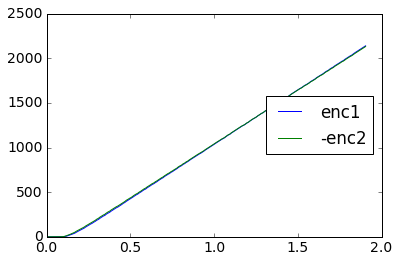

In [61]:
vplotter = data_plotter_sonar(data)
vplotter.encoder_plot()

In [103]:
set_kp_kd(1.8,0.001)
time.sleep(0.2)
print_all(ser)

kp = 1.80
kd*1000 = 1.00



In [104]:
set_stopn(1000)

In [111]:
#start_pd_debug_test()
start_pd_test()
time.sleep(0.1)
data = get_data()

In [107]:
import basic_file_ops

In [108]:
mylist = data.split('\n')

In [109]:
basic_file_ops.writefile('37D_motor_first_comp_filt_test.csv',mylist)

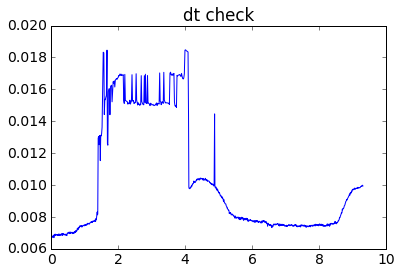

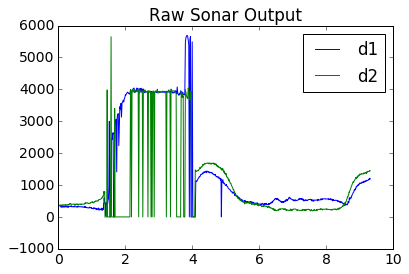

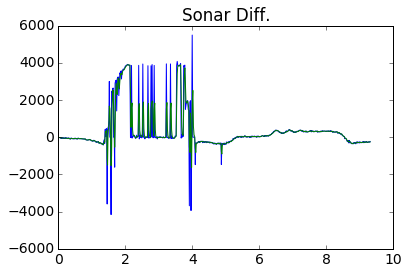

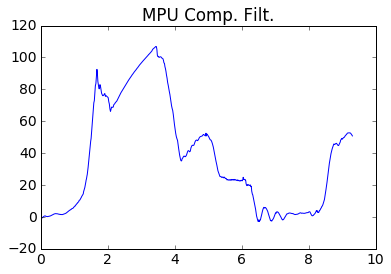

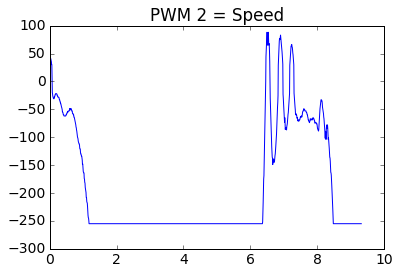

In [112]:
plotter1 = data_plotter_sonar(data)
plotter1.main()

In [31]:
350/25

14.0

In [64]:
set_stopn(1000)

In [65]:
set_kp_kd(1.8,0.001)
time.sleep(0.2)
print_all(ser)

kp = 1.80
kd*1000 = 1.00



In [39]:
daq_no_input()
time.sleep(0.1)
data = get_data()

In [40]:
data

'#====================\r\n#raw_loop_count,n_loop, dt_ms, t_ms, pwm1, pwm2, enc_w1, enc_w2, sonar_diff, dt2, filt_sonar\r\n6498,1,0.31,0.31,0,0,0,0,327,359,-32,3.00,-26.64,-2.33\n6499,2,6.36,6.67,0,0,0,0,359,359,0,3.00,-18.43,-2.33\n6500,3,6.40,13.06,0,0,0,0,363,351,12,3.00,0.42,-2.33\n6501,4,6.46,19.52,0,0,0,0,331,351,-20,3.00,-2.99,-2.33\n6502,5,6.44,25.96,0,0,0,0,335,355,-20,3.00,-16.12,-2.34\n6503,6,6.49,32.45,0,0,0,0,331,351,-20,3.00,-19.11,-2.34\n6504,7,6.50,38.96,0,0,0,0,335,351,-16,3.00,-18.25,-2.34\n6505,8,6.50,45.45,0,0,0,0,355,351,4,3.00,-8.80,-2.34\n6506,9,6.41,51.86,0,0,0,0,359,351,8,3.00,2.62,-2.35\n6507,10,6.42,58.28,0,0,0,0,335,355,-20,3.00,-4.03,-2.35\n6508,11,6.51,64.79,0,0,0,0,331,355,-24,3.00,-17.90,-2.36\n6509,12,6.54,71.33,0,0,0,0,331,355,-24,3.00,-22.61,-2.37\n6510,13,6.57,77.90,0,0,0,0,327,351,-24,3.00,-23.68,-2.37\n6511,14,6.55,84.45,0,0,0,0,359,351,8,3.00,-11.58,-2.38\n6512,15,6.51,90.96,0,0,0,0,331,351,-20,3.00,-7.27,-2.39\n6513,16,6.50,97.46,0,0,0,0,335,355,-

In [67]:
start_pd_test()
time.sleep(0.1)
data = get_data()

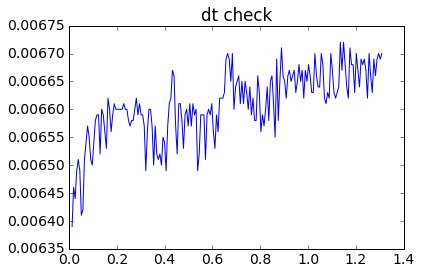

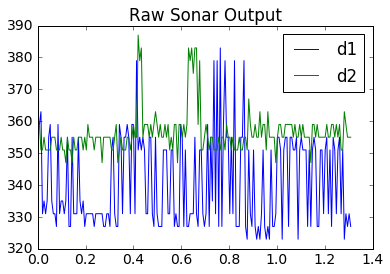

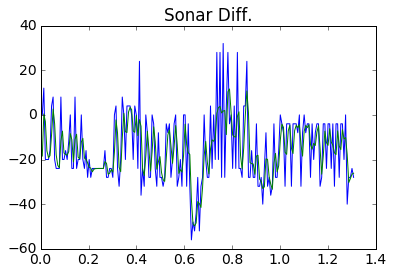

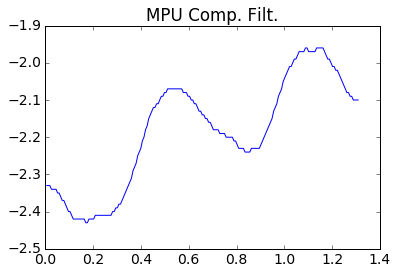

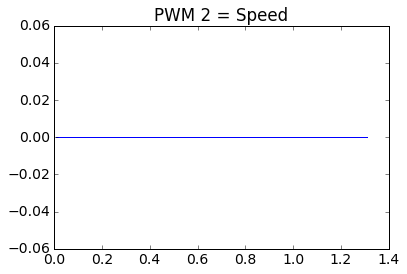

In [41]:
plotter1 = data_plotter_sonar(data)
plotter1.main()

In [1023]:
import basic_file_ops

In [1024]:
mylist = data.split('\n')

In [1025]:
basic_file_ops.writefile('fairly_long_jittery_but_stable_test.csv',mylist)

In [908]:
import os

In [909]:
os.getcwd()

'/Users/kraussry/research/work/mini_segways'

In [318]:
def start_digcomp_test():
    serial_utils.WriteByte(ser, 13)

In [310]:
print_all(ser)

In [355]:
set_b_z_a_z(0.5,5,0.5)
time.sleep(0.1)
print_all(ser)

b_z[0] = 3.92
b_z[1] = -3.68
a_z[0] = 1.00
a_z[1] = -0.52



In [356]:
start_digcomp_test()
time.sleep(0.1)
data = get_data()

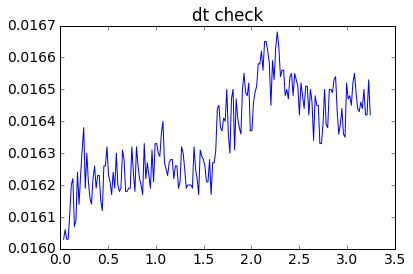

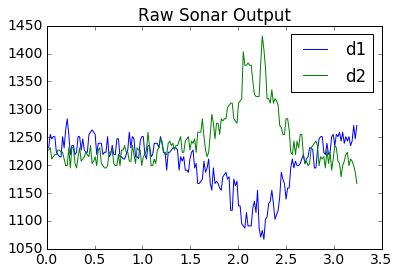

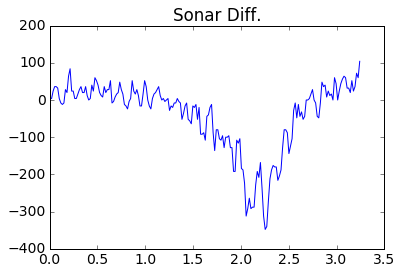

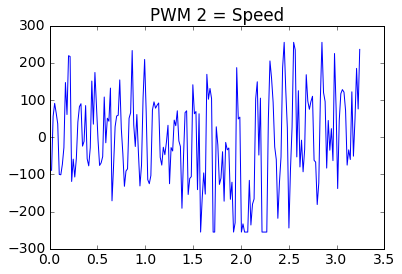

In [357]:
plotter1 = data_plotter_sonar(data)
plotter1.main()

# OL Pulse Testing to Figure Out Velocity difference

In [112]:
start_ol_pulse_test(amp=100, width=300)
time.sleep(0.1)
data = get_data()

end ratio: 0.757


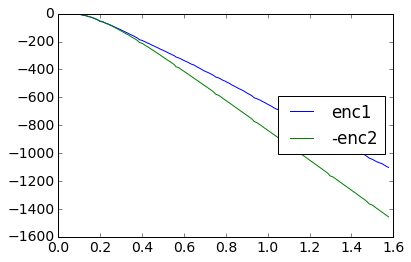

In [113]:
vplotter = data_plotter_sonar(data)
vplotter.encoder_plot()

# Digcomp Design

## Lowpass Design

In [592]:
p = 10*2*np.pi
Gc = control.TransferFunction(p,[1,p])

In [593]:
fs = 50.0#Hz

In [594]:
Gc_z = digcomp.Dig_Comp_from_ctime(Gc, dt=1/fs)
Gc_z.num

array([ 0.38586955,  0.38586955])

In [595]:
Gc_z.den

array([ 1.        , -0.22826091])

## Pure Digcomp with no real design

In [252]:
a = 5*2*np.pi
p = 20*2*np.pi

In [266]:
Gc = control.TransferFunction([1,a],[1,p])*a/p

In [278]:
Gc_z = digcomp.Dig_Comp_from_ctime(Gc, dt=1/fs)
Gc_z.num

array([ 0.14558824, -0.0759804 ])

In [263]:
Gc_z.den

array([ 1.        ,  0.11372545])

In [127]:
kp = 20
kd = 0.5
p = kp/kd
fc = p/(2*np.pi)
dt = 0.01

## Unstable Plant Bode

In [236]:
p = 1.5*2*np.pi
part1 = control.TransferFunction(1,[1,p])
part2 = control.TransferFunction(1,[1,-p])
Gpa = part1*part2
Gp = control.TransferFunction(1,[1,0,-p**2])
Gp


     1
-----------
s^2 - 88.83

In [237]:
Gpa


     1
-----------
s^2 - 88.83

In [241]:
fvect = np.logspace(-2,2,500)
wvect = 2*np.pi*fvect
s = 1.0j*wvect
s

array([ 0. +6.28318531e-02j,  0. +6.40023470e-02j,  0. +6.51946461e-02j,
        0. +6.64091566e-02j,  0. +6.76462921e-02j,  0. +6.89064742e-02j,
        0. +7.01901323e-02j,  0. +7.14977035e-02j,  0. +7.28296336e-02j,
        0. +7.41863761e-02j,  0. +7.55683934e-02j,  0. +7.69761562e-02j,
        0. +7.84101443e-02j,  0. +7.98708461e-02j,  0. +8.13587593e-02j,
        0. +8.28743909e-02j,  0. +8.44182571e-02j,  0. +8.59908840e-02j,
        0. +8.75928073e-02j,  0. +8.92245729e-02j,  0. +9.08867366e-02j,
        0. +9.25798647e-02j,  0. +9.43045341e-02j,  0. +9.60613323e-02j,
        0. +9.78508580e-02j,  0. +9.96737206e-02j,  0. +1.01530541e-01j,
        0. +1.03421953e-01j,  0. +1.05348599e-01j,  0. +1.07311137e-01j,
        0. +1.09310236e-01j,  0. +1.11346575e-01j,  0. +1.13420849e-01j,
        0. +1.15533765e-01j,  0. +1.17686042e-01j,  0. +1.19878415e-01j,
        0. +1.22111628e-01j,  0. +1.24386445e-01j,  0. +1.26703639e-01j,
        0. +1.29063999e-01j,  0. +1.31468331e-01j, 

In [242]:
Gpjw = Gp(s)
Gpjw

array([ -1.12574090e-02-0.j,  -1.12573902e-02-0.j,  -1.12573706e-02-0.j,
        -1.12573504e-02-0.j,  -1.12573294e-02-0.j,  -1.12573075e-02-0.j,
        -1.12572849e-02-0.j,  -1.12572614e-02-0.j,  -1.12572371e-02-0.j,
        -1.12572118e-02-0.j,  -1.12571856e-02-0.j,  -1.12571584e-02-0.j,
        -1.12571301e-02-0.j,  -1.12571008e-02-0.j,  -1.12570704e-02-0.j,
        -1.12570389e-02-0.j,  -1.12570062e-02-0.j,  -1.12569722e-02-0.j,
        -1.12569370e-02-0.j,  -1.12569004e-02-0.j,  -1.12568625e-02-0.j,
        -1.12568231e-02-0.j,  -1.12567823e-02-0.j,  -1.12567399e-02-0.j,
        -1.12566959e-02-0.j,  -1.12566503e-02-0.j,  -1.12566029e-02-0.j,
        -1.12565538e-02-0.j,  -1.12565029e-02-0.j,  -1.12564500e-02-0.j,
        -1.12563951e-02-0.j,  -1.12563382e-02-0.j,  -1.12562791e-02-0.j,
        -1.12562178e-02-0.j,  -1.12561542e-02-0.j,  -1.12560882e-02-0.j,
        -1.12560198e-02-0.j,  -1.12559487e-02-0.j,  -1.12558750e-02-0.j,
        -1.12557985e-02-0.j,  -1.12557191e-02-0.j, 

In [243]:
import bode_utils

In [274]:
fnum = 0.2
fden = 7.0
Gc_s = control.TransferFunction([1,fnum*2*np.pi],[1,fden*2*np.pi])
#Gc_s = control.TransferFunction([kd,kp],1)
L = Gp*Gc_s
Ljw = L(s)

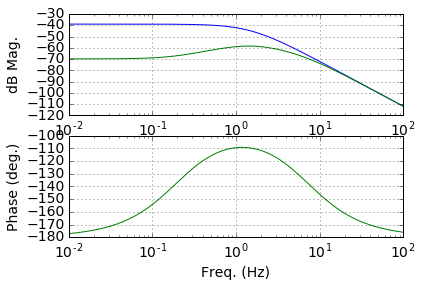

In [275]:
out = bode_utils.bode_plot2(fvect,Gpjw)
out2 = bode_utils.bode_plot2(fvect,Ljw,clear=False)

In [276]:
fc

6.366197723675814

In [280]:
Gc_z = digcomp.Dig_Comp_from_ctime(Gc_s, dt)
Gc_z.num

array([ 0.82488213, -0.81458108])

In [281]:
Gc_z.den

array([ 1.        , -0.63946321])

# DAQ Plot Upside Down

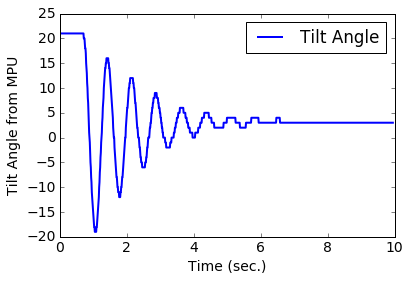

In [1247]:
plt.figure()
plt.plot(t,enc_pend, label='Tilt Angle',linewidth=2)
plt.legend(loc=1)
plt.xlabel('Time (sec.)')
plt.ylabel('Tilt Angle from MPU')
#PU.mysave('daq_test.eps')

In [692]:
dt_vect = t[1:]-t[0:-1]

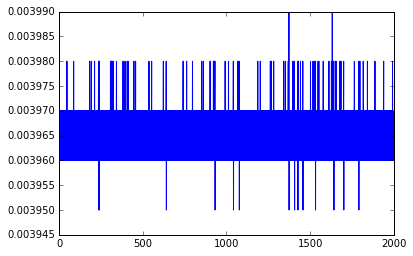

In [319]:
plt.figure()
plt.plot(dt_vect)

In [320]:
dt = dt_vect.mean()

In [321]:
T = t.max()+dt
df = 1/T

In [322]:
df

0.12598698203300282

In [323]:
nvect = np.arange(0,len(t))

In [324]:
freq = df*nvect

In [325]:
freq

array([  0.00000000e+00,   1.25986982e-01,   2.51973964e-01, ...,
         2.51596003e+02,   2.51721990e+02,   2.51847977e+02])

In [326]:
pend_fft = np.abs(np.fft.fft(enc_pend))

(0, 30)

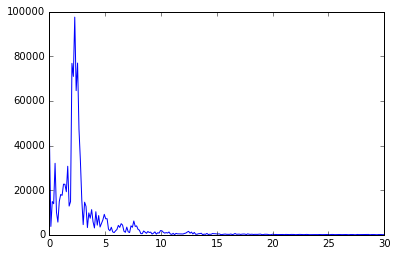

In [328]:
plt.plot(freq,pend_fft)
plt.xlim([0,30])

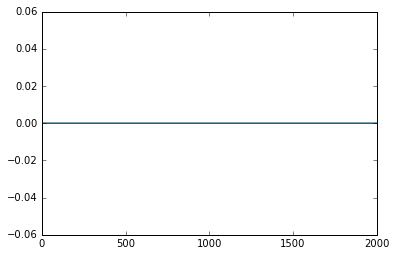

In [213]:
plt.figure()
plt.plot(pwm2)
plt.plot(theta2)

In [1243]:
def save_data(fn,data_str):
    f = open(fn,'w')
    f.write(data_str)
    f.close()

In [1244]:
save_data('upside_down_daq_sys_id_test.csv',data)

In [1248]:
import os
os.getcwd()

'/Users/kraussry/research/work/mini_segways'

In [234]:
ser.close()

# PD Calcs

In [65]:
a = 0.7*2*np.pi
a

4.39822971502571